## What is LassoHull?

LassoHull finds a set of $K$ points that can well approximate $B(\nu)$, where
* $L(\beta) = \frac{1}{2}\|X\beta - y\|^2 + \rho \|\beta\|_1$ is the Lasso objective function.
* $B(\nu) = \{\beta : L(\beta) \le \nu\}$ is the set of good Lasso models.

---
## Problem: Approximation of $B(\nu)$

<div style="background-color:rgba(0, 0, 200, 0.10); text-align:left; vertical-align: top; padding:1pt 0pt 5pt 3pt; margin-top: 5pt;">
<h3>Minimization of Hausdorff distance</h3>
<br>
&nbsp; $\min_{Q} d_H(\mathrm{conv}(Q), B(\nu))$ s.t. $|Q| \le K$
</div>
<ul>
    <li>$d_H$ is the Hausdorff distance between the sets.</li>
    <ul><li> $d_H(C, C') := \max \{\sup_{\beta \in C} \inf_{\beta' \in C'} \|\beta - \beta'\|, \sup_{\beta' \in C'} \inf_{\beta \in C} \|\beta - \beta'\|\}$</li></ul>
</ul>

---
## LassoHull Algorithm
The algorithm of LassoHull consists of the two steps.
1. Sampling points from the boundary of $B(\nu)$.
2. Greedily select $K$ points from the sampled points.

In [1]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import cd_fast
from sklearn.utils.validation import check_random_state
import cvxopt

---
### Step1: Sampling

* Take a random direction $d$.
* Find an "edge" of $B(\nu)$ in the direction $d$.

<div style="background-color:rgba(0, 0, 200, 0.10); text-align:left; vertical-align: top; padding:1pt 0pt 5pt 3pt; margin-top: 5pt;">
<h4>Finding an "edge"</h4>
<ul>
    <li> $\max_\beta d^\top \beta$ s.t. $\beta \in B(\nu)$
    <ul><li>$d \in \mathbb{R}^p$: random direction</ul>
</ul>
</div>
    
#### Solve the dual problem by using binary serach.
- Dual Problem: $\min_{\tau \ge 0} \max_\beta d^\top \beta - \tau (L(\beta) - \nu)$
    - The latter $\max_\beta$ is a modified Lasso, and can be solved given $\tau$ fixed.
    - Find an optimal $\tau$ so that $L(\beta) = \nu$ to hold by using binary search.

In [2]:
##### Methods for Step1 #####

# Lasso objective function value
def lasso_obj(beta, X, y, rho):
    n = y.size
    res = y - X.dot(beta)
    return 0.5 * res.dot(res) / n + rho * np.linalg.norm(beta, 1)
    
# Solve Lasso
def fit_lasso(X, y, rho, max_iter=1000, tol=1e-5):
    lasso = Lasso(fit_intercept=False, alpha=rho, max_iter=max_iter, tol=tol)
    lasso.fit(X, y)
    return lasso.coef_

# Solve Lasso with an additional linear term
def fit_lasso_withlin(XX, Xy, yn, rho, d, tau, max_iter=1000, tol=1e-5):

    # vectors & matrices
    n = yn.size
    p = Xy.size
    Q = XX * tau / n
    q = Xy * tau / n + d

    # fit
    rng = check_random_state(0)
    beta = np.zeros(p)
    res = cd_fast.enet_coordinate_descent_gram(beta, tau * rho, 0, Q, q, yn, max_iter, tol, rng)
    return res[0]

# Find a boundary point of B(\nu) in direction d
def find_lasso_extreme(X, y, rho, d, nu, max_iter=1000, tol=1e-5, eps=1e-5):
    
    # vectors & matrices
    XX = X.T.dot(X)
    Xy = X.T.dot(y)
    yn = y / np.sqrt(y.size)
    
    # binary search
    tau_prev = 1.0
    beta = fit_lasso_withlin(XX, Xy, yn, rho, d, tau_prev, max_iter=max_iter, tol=tol)
    obj_prev = lasso_obj(beta, X, y, rho)
    if obj_prev >= nu:
        tau = tau_prev * 2.0
    else:
        tau = tau_prev * 0.5
    for i in range(20):
        beta = fit_lasso_withlin(XX, Xy, yn, rho, d, tau, max_iter=max_iter, tol=tol)
        obj = lasso_obj(beta, X, y, rho)
        if obj >= nu:
            tau_prev = tau
            tau *= 2.0
        else:
            tau_prev = tau
            tau *= 0.5
        if (obj >= nu and obj_prev < nu) or (obj_prev >= nu and obj < nu):
            break
    tau_lb = min(tau, tau_prev)
    tau_ub = max(tau, tau_prev)
    for i in range(20):
        tau = 0.5 * (tau_lb + tau_ub)
        beta = fit_lasso_withlin(XX, Xy, yn, rho, d, tau, max_iter=max_iter, tol=tol)
        obj = lasso_obj(beta, X, y, rho)
        if obj >= nu:
            tau_lb = tau
        else:
            tau_ub = tau
        if obj <= nu and nu - obj < eps:
            break
    return beta

---
### Step2: Greedy Selection

#### Sampling-based approximation of Hausdorff distance
- Let $S$ be the set of sampled points in Step1.
- Approximate $B(\nu)$ by $\mathrm{conv}(S)$.
<div style="background-color:rgba(0, 0, 200, 0.10); text-align:left; vertical-align: top; padding:10pt 0pt 5pt 3pt; margin-top: 5pt;">
$\min_{Q \subseteq S} d_H(\mathrm{conv}(Q), \mathrm{conv}(S))$ s.t. $|Q| \le K$
<ul><li>$d_H(\mathrm{conv}(Q), \mathrm{conv}(S)) = \max_{\beta \in S} \min_{\beta' \in \mathrm{conv}(Q)} \|\beta - \beta'\|$</ul>
</div>

#### Greedy Selection
- Select the "furthest" point $\hat{\beta} \in S$ from the current $Q$, and add $\hat{\beta}$ to $Q$.
<div style="background-color:rgba(0, 0, 200, 0.10); text-align:left; vertical-align: top; padding:10pt 0pt 5pt 3pt; margin-top: 15pt;">
$Q^{[1]} \leftarrow \{\beta_1 \in S\}$, $S \leftarrow S \setminus \{\beta_1\}$, $k \leftarrow 1$<br>
while $k < K$: <br>
&nbsp; &nbsp; &nbsp; $\hat{\beta} \in \arg\max_{\beta \in S} \min_{\beta' \in \mathrm{conv}(Q^{[k]})} \|\beta - \beta'\|$<br>
&nbsp; &nbsp; &nbsp; $Q^{[k+1]} \leftarrow Q^{[k]} \cup \{\hat{\beta}\}$, $S \leftarrow S \setminus \{\hat{\beta}\}$, $k \leftarrow k+1$
</div>

In [3]:
##### Methods for Step2 #####

def project_to_hull(beta, Q):
    m = Q.shape[1]
    P = cvxopt.matrix(Q.T.dot(Q))
    q = cvxopt.matrix(-Q.T.dot(beta))
    A = cvxopt.matrix(np.ones((1,m)))
    b = cvxopt.matrix(np.array([1.0]))
    G = cvxopt.matrix(-np.identity(m))
    h = cvxopt.matrix(np.zeros(m))
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(P,q,A=A,b=b,G=G,h=h)
    ans = np.transpose(np.array(sol['x'])).dot(Q.T)
    return ans[0]

# initialize Q
def initializeQ(beta_opt, S):
    idx = [j for j in range(len(S))]
    i = np.argmax([np.linalg.norm(beta_opt - b) for b in S])
    idx.remove(i)
    Q = S[i][:, np.newaxis]
    dist = []
    dist_ub = np.array([np.infty] * (len(idx) + 1))
    dist_ub[i] = 0
    return Q, idx, dist, dist_ub

# select K points as Q from S
def select(beta_opt, S, K=10):
    Q, idx, dist, dist_ub = initializeQ(beta_opt, S)
    for k in range(K):
        i_max = 0
        d_max = 0
        ctmp = 0
        jdx = np.argsort(dist_ub[idx])[::-1]
        for i in jdx:
            ii = idx[i]
            if d_max > dist_ub[ii]:
                break
            ctmp += 1
            b = project_to_hull(S[ii], Q)
            d = np.linalg.norm(S[ii] - b)
            dist_ub[ii] = d
            if d > d_max:
                i_max = ii
                d_max = d
        Q = np.c_[Q, S[i_max]]
        dist_ub[i_max] = 0
        dist.append(d_max)
        idx.remove(i_max)
    return Q

---
## A Synthetic Example on Two Dimensional Data

In [4]:
# synthetic data in p=2
X = np.array([[1, 1], [1, 1+1/40]])
y = np.ones(2)
rho = 1.0 / 2

In [5]:
# solve Lasso
beta_opt = fit_lasso(X, y, rho)
obj_opt = lasso_obj(beta_opt, X, y, rho)
print('beta = ', beta_opt)
print('obj = ', obj_opt)

beta =  [0.         0.49984761]
obj =  0.371914050594331


### Step1

<IPython.core.display.Javascript object>


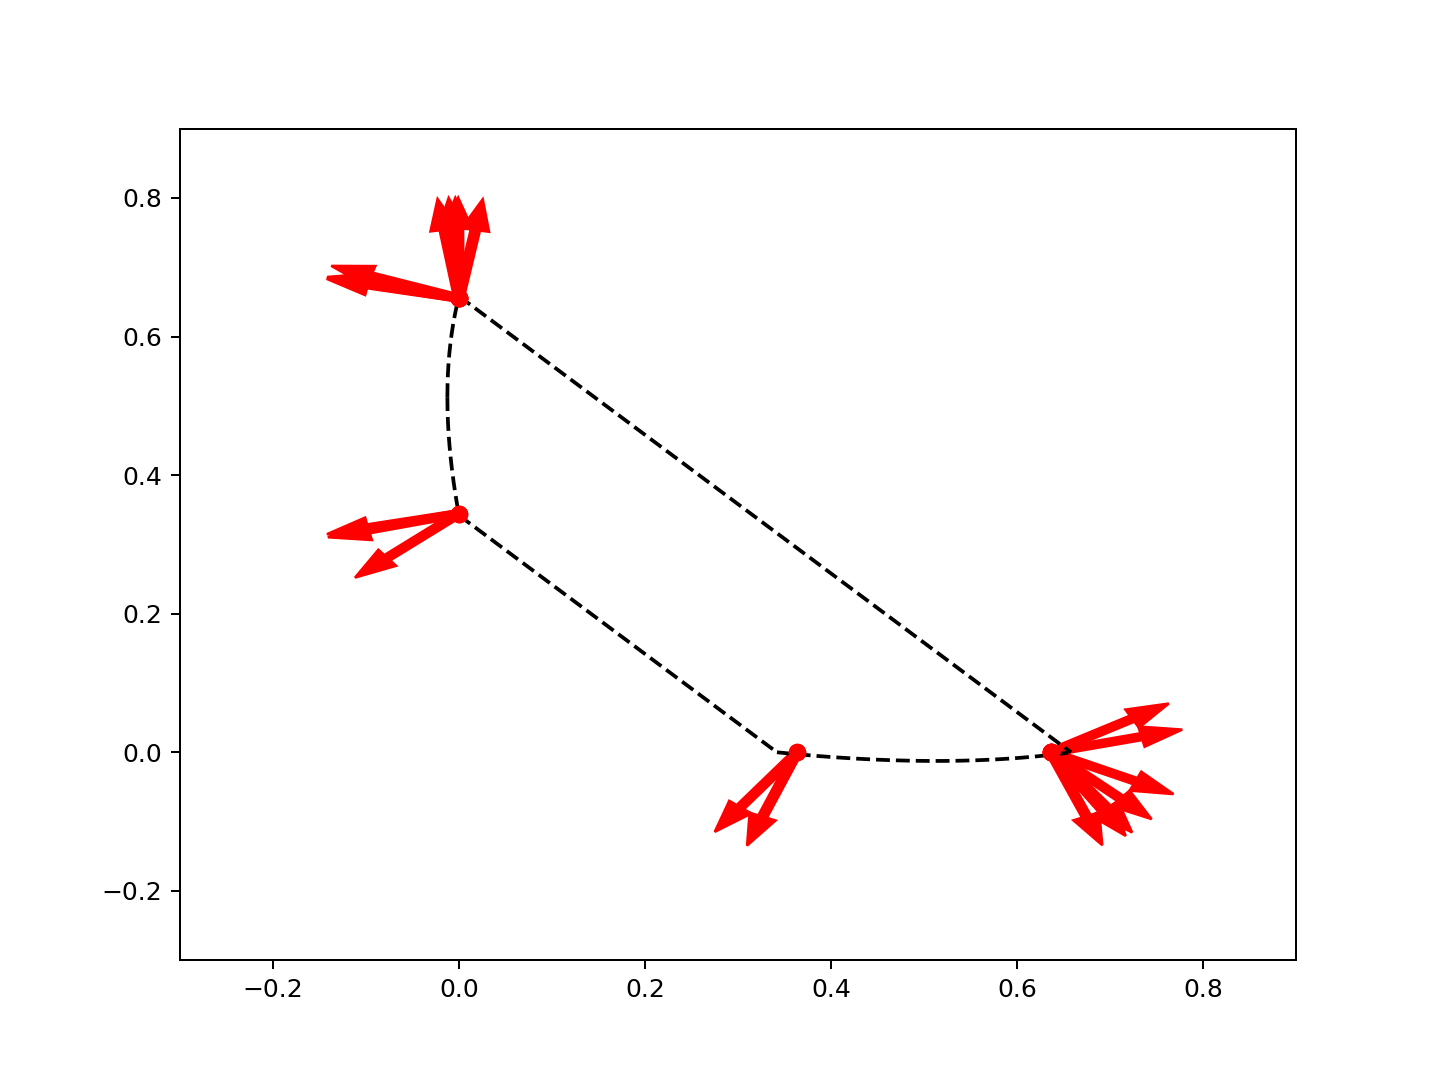

In [6]:
%matplotlib notebook
from matplotlib import pyplot as plt
import time

# plot B(nu)
fig = plt.figure(figsize=(8, 6))
t = np.linspace(0, (10 + np.sqrt(10))/20, 200)
plt.plot(t, (1/np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace(0, (10 - np.sqrt(10))/20, 200)
plt.plot(t, (-1/np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace(-1 / 80, 0, 200)
plt.plot(t, (np.sqrt(80 * t + 1) / np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace(-1/ 80, 0, 200)
plt.plot(t, (-np.sqrt(80 * t + 1) / np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace((10 - np.sqrt(10)) / 20, (10 + np.sqrt(10)) / 20, 200)
plt.plot(t, (3 - 2 * t - np.sqrt(81 - 40 * t - 40 * np.abs(t)) / np.sqrt(10)) / 2, 'k--')

# sampling from the boundary
nu=31/30
p = X.shape[1]
M = 20 # number of sampling points
seed = 100 # random seed
S = []
for m in range(M):
    np.random.seed(seed+m)
    d = np.random.randn(p) # random direction
    d /= np.linalg.norm(d)
    beta_m = find_lasso_extreme(X, y, rho, d, nu * obj_opt)
    S.append(beta_m)
    plt.plot(beta_m[0], beta_m[1], 'ro')
    plt.arrow(beta_m[0], beta_m[1], 0.1 * d[0], 0.1 * d[1], width=0.01, color='red')
    plt.xlim([-0.3, 0.9])
    plt.ylim([-0.3, 0.9])
    fig.canvas.draw()
    time.sleep(1)

### Step2

<IPython.core.display.Javascript object>


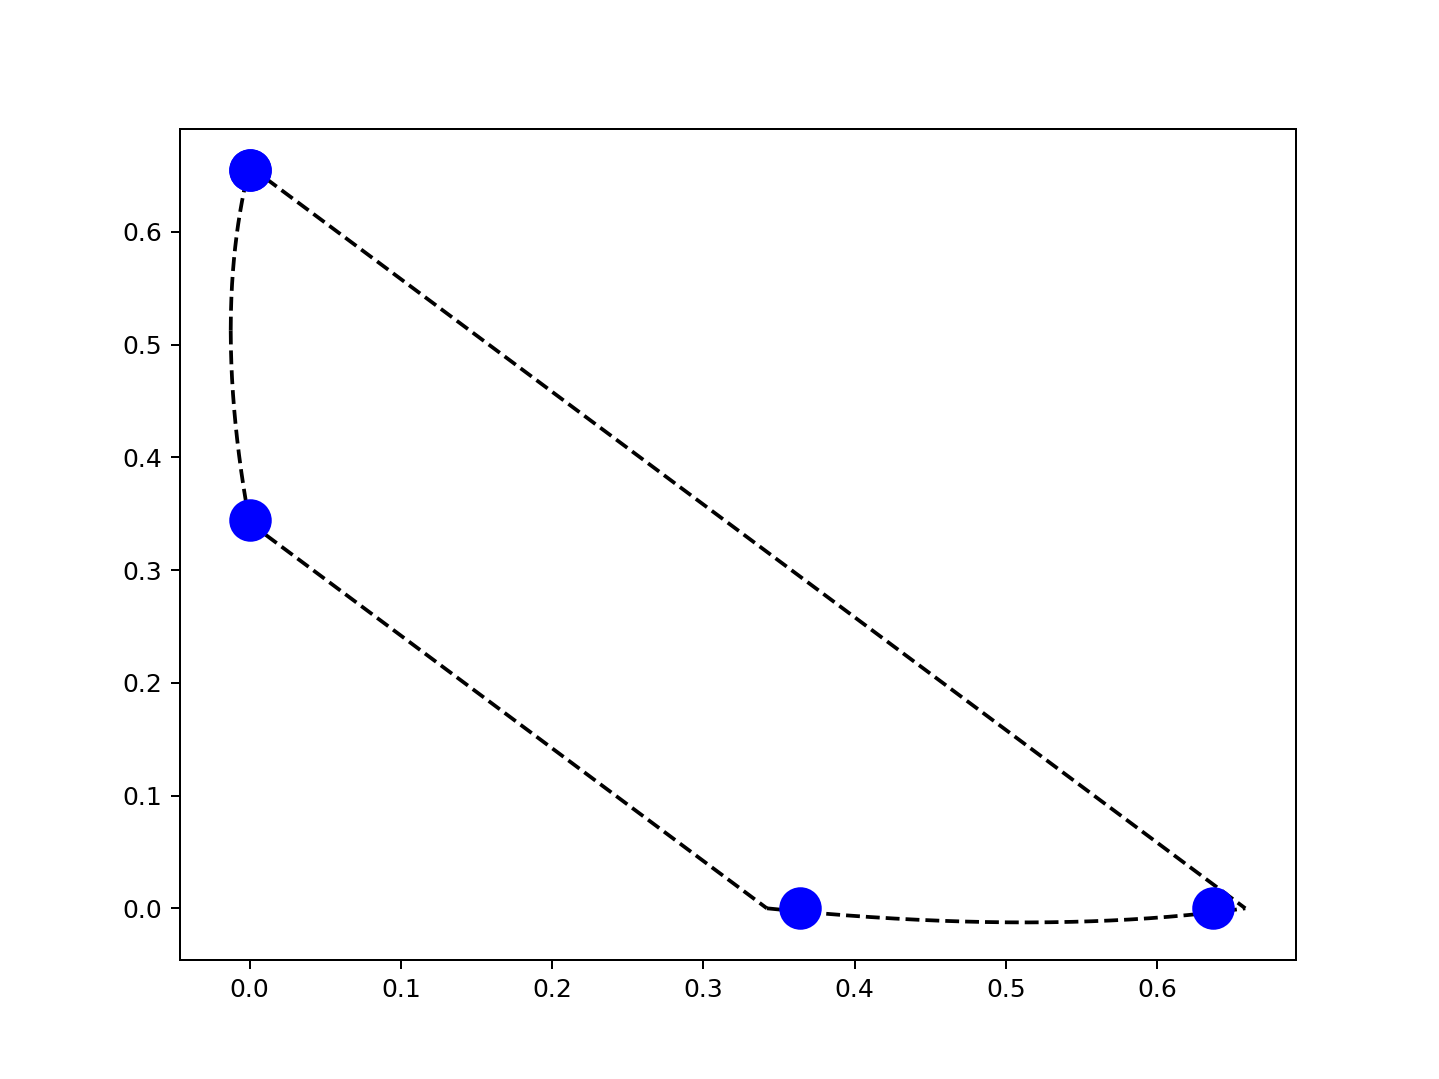

In [7]:
# plot B(nu)
fig = plt.figure(figsize=(8, 6))
t = np.linspace(0, (10 + np.sqrt(10))/20, 200)
plt.plot(t, (1/np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace(0, (10 - np.sqrt(10))/20, 200)
plt.plot(t, (-1/np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace(-1 / 80, 0, 200)
plt.plot(t, (np.sqrt(80 * t + 1) / np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace(-1/ 80, 0, 200)
plt.plot(t, (-np.sqrt(80 * t + 1) / np.sqrt(10) - 2 * t + 1) / 2, 'k--')
t = np.linspace((10 - np.sqrt(10)) / 20, (10 + np.sqrt(10)) / 20, 200)
plt.plot(t, (3 - 2 * t - np.sqrt(81 - 40 * t - 40 * np.abs(t)) / np.sqrt(10)) / 2, 'k--')

# plot S
for b in S:
    plt.plot(b[0], b[1], 'ro', ms=12)

# plot Q
Q = select(beta_opt, S, K=4)
for k in range(Q.shape[1]):
    plt.plot(Q[0, k], Q[1, k], 'bo', ms=16)
    fig.canvas.draw()
    time.sleep(1)